## 1. Grid Search and Random Search

In [1]:
from Basic import names,name_parameter,name_model
from evaluator import X,y,df_name

from time import time
import pandas as pd
import random
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#print(__doc__)

Loading the dataset: datasets/dataset_3.csv


In [2]:
# Utility function to report best scores
def report(results):
    candidate = np.flatnonzero(results['rank_test_score'] == 1)[0]
    return results['mean_test_score'][candidate],results['params'][candidate]

### 1. Grid Search

In [3]:
def grid_search_one_class(name):
    clf = name_model[name]
    param_grid = name_parameter[name]
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False)
    start = time()
    grid_search.fit(X, y)
    used_time = time() - start
    score,parameter = report(grid_search.cv_results_)
    n_iter = len(grid_search.cv_results_['params'])
    return (used_time,score,parameter,n_iter)

In [4]:
def whole_grid_search():
    history = [grid_search_one_class(name) for name in names]
    return history

In [5]:
def grid_search_history(history):
    times = [h[0] for h in history]
    scores = [h[1] for h in history]
    parameters = [h[2] for h in history]
    n_iters = [h[3] for h in history]
    
    
    ind = scores.index(max(scores))
    print('Iterations: ',sum(n_iters))
    print('Time: ',sum(times))
    print('Best score: ',max(scores))
    print('Best classifier: ',names[ind])
    print('Best parameter: ',parameters[ind])
    
    return times,scores,parameters,n_iters

### 2. Random Search

In [6]:
def random_search_one_class(name,n_iter=1):
    clf = name_model[name]
    param_grid = name_parameter[name]
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=n_iter,cv=5, iid=False)
    start = time()
    random_search.fit(X, y)
    used_time = time() - start
    score,parameter = report(random_search.cv_results_)
    return (used_time,score,parameter,name) 

In [7]:
def whole_random_search(n_playouts = 100):
    history = [random_search_one_class(random.choice(names)) for _ in range(n_playouts)]
    return history

In [8]:
def random_search_history(history):
    times = [h[0] for h in history]
    scores = [h[1] for h in history]
    parameters = [h[2] for h in history]
    clf_names = [h[3] for h in history]
    
    ind = scores.index(max(scores))
    print('Iterations: ',len(clf_names))
    print('Time: ',sum(times))
    print('Best score: ',max(scores))
    print('Best classifier: ',clf_names[ind])
    print('Best parameter: ',parameters[ind])
    
    return times,scores,parameters,clf_names

In [9]:
def convert_times_and_scores(times,scores):
    cum_times = [sum(times[:t]) for t in range (1,len(clf_names)+1)]
    max_score = [max(scores[:s]) for s in range (1,len(clf_names)+1)]
    cum_playouts = [i+1 for i in range(len(clf_names))]
    return cum_times,max_score,cum_playouts

### 3. RS vs MCTS

##### Grid Search

In [ ]:
history_gs = whole_grid_search()

In [ ]:
times_gs,score_gs,parameter_gs,n_iter_gs = grid_search_history(history_gs)

##### Random Search

In [ ]:
history_rs = whole_random_search(n_playouts=5)

In [ ]:
history_rs

In [ ]:
times,scores,parameters,clf_names= random_search_history(history_rs)

In [ ]:
times_rs,score_rs,playouts = convert_times_and_scores(times,scores)

##### MCTS

In [ ]:
from agent import Agent
from evaluator import policy_value_fn

In [ ]:
def whole_mcts(n_playout=100):
    agent = Agent(policy_value_fn,n_playout=n_playout)
    times,visit_times,Q_values = agent.play_outs()
    
    total_time = max(times)
    best_score = max(agent.mcts._storage.score)
    best_parameter = agent.mcts._storage.parameter[agent.mcts._storage.score.index(best_score)]
    print(total_time,best_score,best_parameter)
    
    return times,agent,visit_times,Q_values

In [ ]:
n_playout = 100
times_mcts,agent,visit_times,Q_values = whole_mcts(n_playout=n_playout)

In [ ]:
scores_mcts = [max(agent.mcts._storage.score [:ind]) for ind in playouts ]

##### Compare between RS and MCTS
Time: Times vs cum_times  
Score: best_scores_mcts vs max_score

##### Score

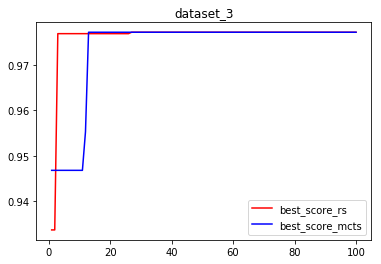

In [27]:
import matplotlib.pyplot as plt
fig,ax1 = plt.subplots()
plt.plot(playouts,score_rs,color ='r',label='best_score_rs')
plt.plot(playouts,scores_mcts,color ='b',label='best_score_mcts')
plt.legend()
plt.title(df_name)
plt.savefig('store/'+df_name+'score')
#plt.show()

##### Time

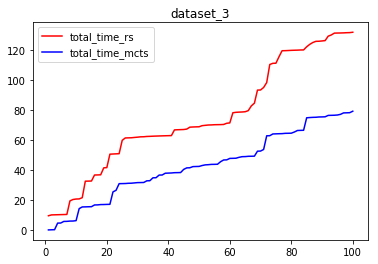

In [28]:
import matplotlib.pyplot as plt
fig,ax1 = plt.subplots()
plt.plot(playouts,times_rs,color ='r',label='total_time_rs')
plt.plot(playouts,times_mcts,color ='b',label='total_time_mcts')
plt.legend()
plt.title(df_name)
plt.savefig('store/'+df_name+'time')

##### Why RS use more time than MCTS
RS used more time because it visit more time of adaboost than ever  
RS cv=3   MCTS cv=5

In [165]:
[i._n_visits for i in list(agent.mct.root._children.values())]

[8, 8, 9, 8, 8, 8, 9, 8, 9, 7, 9, 8]

In [166]:
from collections import Counter

In [167]:
Counter(clf_names)

Counter({'LDA': 8,
         'SVC': 5,
         'KNN': 15,
         'AdaBoostClassifier': 12,
         'SGD': 8,
         'ExtraTree': 11,
         'PAC': 10,
         'QDA': 3,
         'RF': 7,
         'BernoulliNB': 8,
         'LSVC': 8,
         'DecisionTree': 5})

## 2. MCTS with one feature